<a href="https://colab.research.google.com/github/albert-magarire/Leetcode-Solutions/blob/main/DSCI_230_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.impute import SimpleImputer

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Loading & Cleaning Data

In [7]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ARbike(1) (1).csv')
df.columns

Index(['STATION', 'DATE', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'NAME',
       'PRCP_MM', 'TMAX_10THC', 'TMIN_10THC', 'AWND_MTRSPERSEC', 'CASUAL',
       'REGISTERED ', 'TTLCNT'],
      dtype='object')

In [8]:
df.columns = df.columns.str.strip()

# Converting "DATE" to datetime and making it the index
df['DATE'] = pd.to_datetime(df['DATE'], format='%m/%d/%Y')
df.set_index('DATE', inplace=True)

# Handling Missing Data

In [9]:
# Impute missing weather values
imp = SimpleImputer(strategy='median')
weather_cols = ['TMAX_10THC', 'TMIN_10THC', 'AWND_MTRSPERSEC']
df[weather_cols] = imp.fit_transform(df[weather_cols])

# IQR outlier removal
def drop_iqr(df, col):
    q1, q3 = df[col].quantile([0.25, 0.75])
    iqr = q3 - q1
    mask = (df[col] >= q1 - 1.5 * iqr) & (df[col] <= q3 + 1.5 * iqr)
    return df.loc[mask]

# removing outlier
df = drop_iqr(df, 'PRCP_MM')
df = drop_iqr(df, 'TTLCNT')

In [10]:
# Feature Engineering

In [11]:
# Temp in °C
df['TMAX_C'] = df['TMAX_10THC'] / 10.0
df['TMIN_C'] = df['TMIN_10THC'] / 10.0

df['TEMP_RANGE_C'] = df['TMAX_C'] - df['TMIN_C']

# Weather Condition
conditions = [
    df['PRCP_MM'] > 5,
    (df['PRCP_MM'] > 0) & (df['PRCP_MM'] <= 5),
    df['TMAX_C'] > 30
]

choices = ['Heavy Rain', 'Light Rain', 'Heatwave']
df['Weather_Condition'] = np.select(conditions, choices, default='Normal')

# Slicing & Stats

In [12]:
# Stats
extreme = df[df['Weather_Condition'].isin(['Heavy Rain', 'Heatwave'])]
print(extreme[['CASUAL', 'REGISTERED']].describe())

            CASUAL   REGISTERED
count    66.000000    65.000000
mean   1038.242424  3293.123077
std     588.451163   732.385070
min     118.000000   889.000000
25%     669.250000  2915.000000
50%     800.000000  3348.000000
75%    1454.000000  3848.000000
max    2521.000000  4488.000000


In [13]:
# .loc slice first week of July 2021
df.loc['2021-07-01':'2021-07-07', ['CASUAL', 'REGISTERED']]

# .iloc first 5 rows, last 3 columns
df.iloc[:5, -3:]

,TMIN_C,TEMP_RANGE_C,Weather_Condition
DATE,,,
2021-01-02,-1.0,2.1,Normal
2021-01-03,-3.2,16.5,Normal
2021-01-04,-2.7,14.9,Normal
2021-01-05,-3.8,18.2,Normal
2021-01-08,-1.0,3.8,Normal


from matplotlib import pyplot as plt
_df_0['TMIN_C'].plot(kind='hist', bins=20, title='TMIN_C')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['TEMP_RANGE_C'].plot(kind='hist', bins=20, title='TEMP_RANGE_C')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2.plot(kind='scatter', x='TMIN_C', y='TEMP_RANGE_C', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['TMIN_C'].plot(kind='line', figsize=(8, 4), title='TMIN_C')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_4['TEMP_RANGE_C'].plot(kind='line', figsize=(8, 4), title='TEMP_RANGE_C')
plt.gca().spines[['top', 'right']].set_visible(False)

In [14]:
# Joins & Merges

In [15]:
weather_df = df[['PRCP_MM', 'TMAX_C', 'TMIN_C', 'AWND_MTRSPERSEC']].reset_index()
rides_df   = df[['CASUAL', 'REGISTERED', 'TTLCNT']].reset_index()

# inner merge
merge_inner = weather_df.merge(rides_df, on='DATE', how='inner')

# left join
join_left   = weather_df.set_index('DATE').join(rides_df.set_index('DATE'), how='left')
print(merge_inner.shape)
print(join_left.shape)

(281, 8)
(281, 7)


# Rolling Stats

In [16]:
df['TTLCNT_7D_MA'] = df['TTLCNT'].rolling(window=7, min_periods=1).mean()
print(df['TTLCNT_7D_MA'].head())

DATE
2021-01-02     801.000000
2021-01-03    1075.000000
2021-01-04    1237.333333
2021-01-05    1328.000000
2021-01-08    1254.200000
Name: TTLCNT_7D_MA, dtype: float64


In [30]:
from scipy.stats import ttest_ind

# Compare ridership on rainy vs. non-rainy days
rain = df[df['Weather_Condition'].isin(['Heavy Rain', 'Light Rain'])]['TTLCNT']
no_rain = df[df['Weather_Condition'] == 'Normal']['TTLCNT']
t_stat, p_val = ttest_ind(rain, no_rain)
print(f'P-value for rain vs. no rain: {p_val:.4f}')

P-value for rain vs. no rain: 0.7836


# Visuals

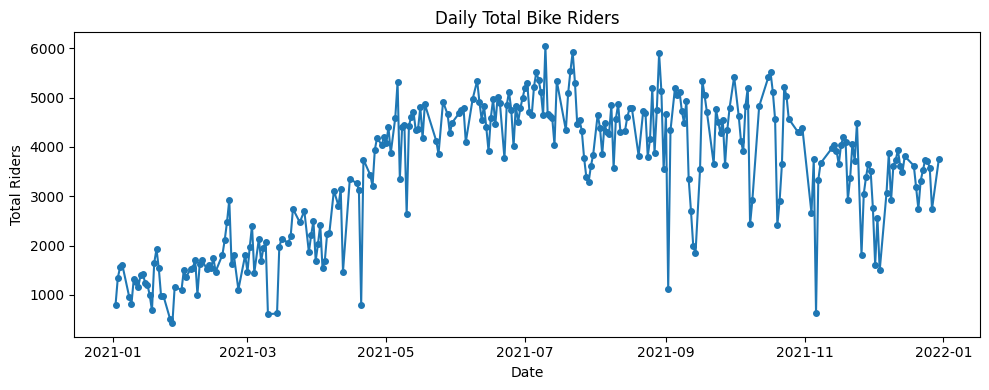

In [28]:
# Line plot with point markers
plt.figure(figsize=(10, 4))
plt.plot(df.index, df['TTLCNT'], marker='o', linestyle='-', markersize=4)
plt.title('Daily Total Bike Riders')
plt.xlabel('Date')
plt.ylabel('Total Riders')
plt.tight_layout()
plt.show()

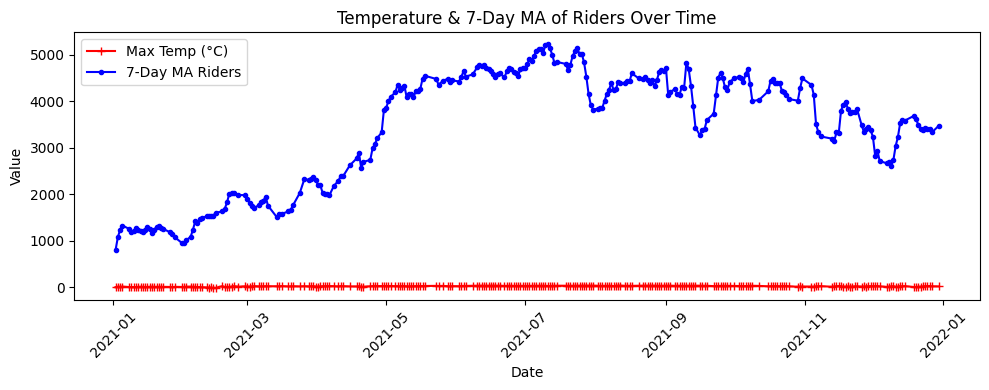

In [18]:
# Line plot with tick labels adjusted, color added, and legend displayed
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(df.index, df['TMAX_C'], color='red', marker='+', label='Max Temp (°C)')
ax.plot(df.index, df['TTLCNT_7D_MA'], color='blue', marker='.', label='7-Day MA Riders')
plt.xticks(rotation=45)
plt.title('Temperature & 7-Day MA of Riders Over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.tight_layout()
plt.show()

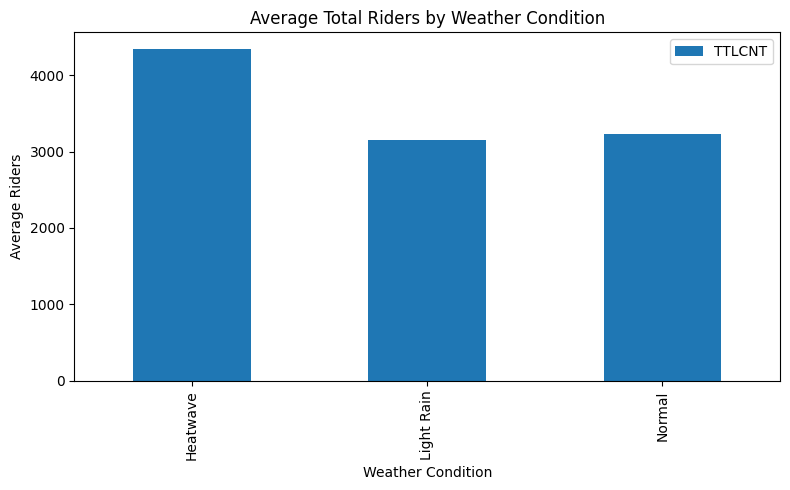

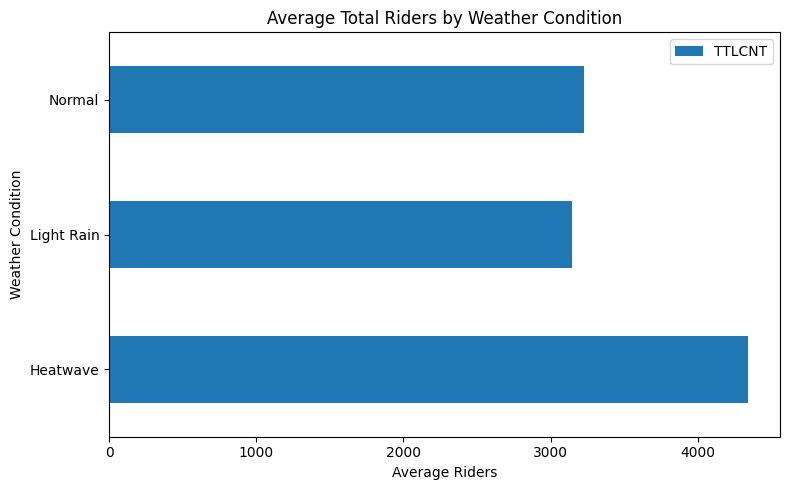

In [19]:
# Vertical bar plot
pivot = df.pivot_table(index='Weather_Condition',
                       values='TTLCNT', aggfunc='mean')
pivot.plot(kind='bar', figsize=(8, 5))
plt.title('Average Total Riders by Weather Condition')
plt.xlabel('Weather Condition')
plt.ylabel('Average Riders')
plt.tight_layout()
plt.show()

# Horizontal bar plot
pivot.plot(kind='barh', figsize=(8, 5))
plt.title('Average Total Riders by Weather Condition')
plt.xlabel('Average Riders')
plt.ylabel('Weather Condition')
plt.tight_layout()
plt.show()

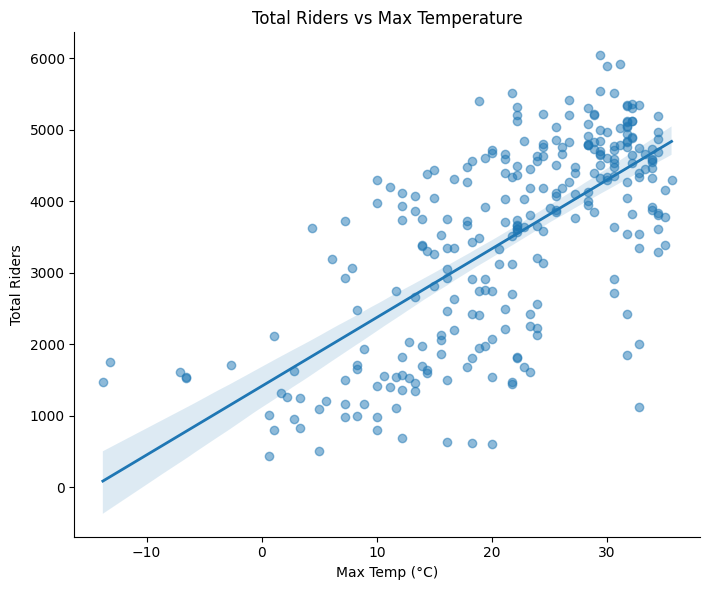

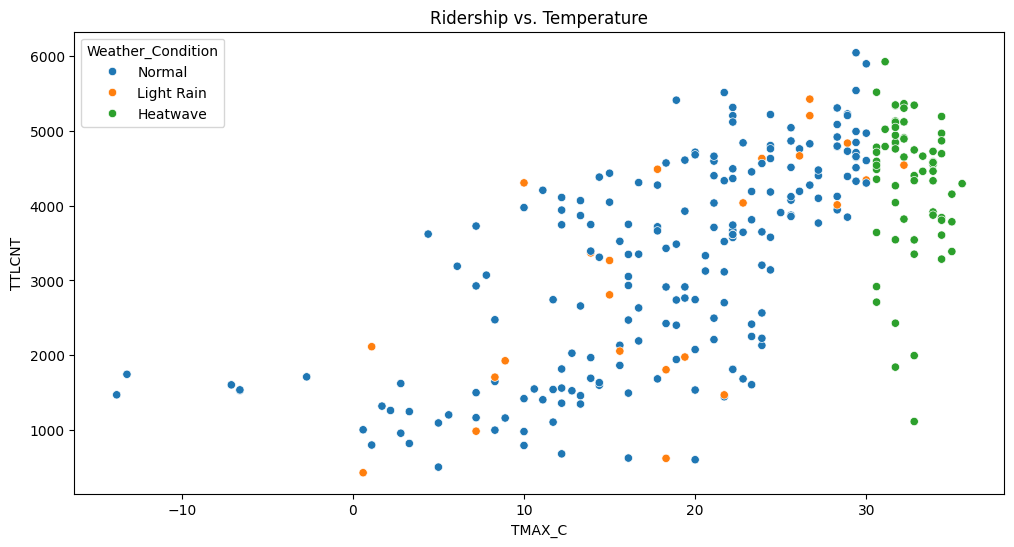

In [29]:
# 8.5 Scatter plot with a linear regression line fitted
sns.lmplot(
    data=df, x='TMAX_C', y='TTLCNT',
    height=6, aspect=1.2,
    scatter_kws={'alpha': 0.5},
    line_kws={'linewidth': 2}
)
plt.title('Total Riders vs Max Temperature')
plt.xlabel('Max Temp (°C)')
plt.ylabel('Total Riders')
plt.tight_layout()
plt.show()
# Plot total rides vs. temperature
plt.figure(figsize=(12, 6))
sns.scatterplot(x='TMAX_C', y='TTLCNT', data=df, hue='Weather_Condition')
plt.title('Ridership vs. Temperature')
plt.show()

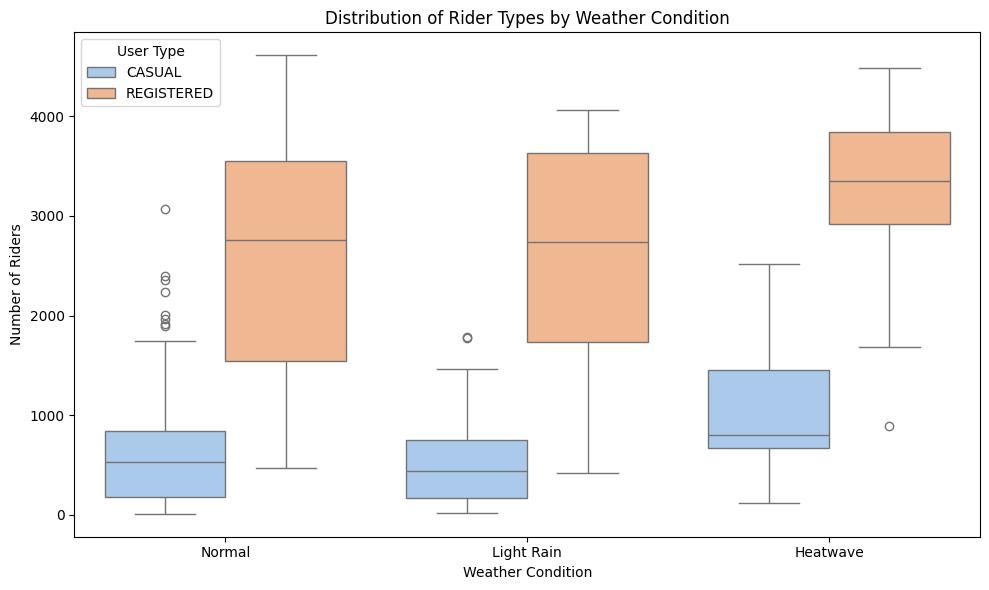

In [21]:
# Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df.melt(id_vars='Weather_Condition',
                 value_vars=['CASUAL', 'REGISTERED']),
    x='Weather_Condition', y='value', hue='variable',
    palette='pastel'
)
plt.title('Distribution of Rider Types by Weather Condition')
plt.xlabel('Weather Condition')
plt.ylabel('Number of Riders')
plt.legend(title='User Type')
plt.tight_layout()
plt.show()

# Groupby & Periods

In [22]:
# Monthly max\min (period index)
do_monthly = df.groupby(df.index.to_period('M')).agg({
    'CASUAL':['max','min'],
    'REGISTERED':['max','min']
})
print(do_monthly.head())

        CASUAL      REGISTERED        
           max  min        max     min
DATE                                  
2021-01    251    9     1844.0   416.0
2021-02    639   42     2348.0   905.0
2021-03   1047   46     2320.0   491.0
2021-04   1710  121     3444.0   674.0
2021-05   1965  255     4169.0  2213.0


In [23]:
# Yearly correlations
corr_yearly = df.resample('YE')[['CASUAL','REGISTERED','PRCP_MM','TMAX_C']].corr()
print(corr_yearly.head())

              CASUAL  REGISTERED   PRCP_MM    TMAX_C
CASUAL      1.000000    0.405259 -0.094583  0.521596
REGISTERED  0.405259    1.000000 -0.055613  0.610579
PRCP_MM    -0.094583   -0.055613  1.000000 -0.104912
TMAX_C      0.521596    0.610579 -0.104912  1.000000


# Linear Regression Mondeling

In [24]:
formula = 'TTLCNT ~ PRCP_MM + TMAX_C + PRCP_MM:TMAX_C'
model = smf.ols(formula=formula, data=df).fit()

In [25]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 TTLCNT   R-squared:                       0.463
Model:                            OLS   Adj. R-squared:                  0.457
Method:                 Least Squares   F-statistic:                     79.67
Date:                Fri, 25 Apr 2025   Prob (F-statistic):           3.46e-37
Time:                        18:02:49   Log-Likelihood:                -2344.4
No. Observations:                 281   AIC:                             4697.
Df Residuals:                     277   BIC:                             4711.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       1440.3898    154.884      9.

In [32]:
import statsmodels.api as sm

# Model ridership using weather features
X = df[['TMAX_C', 'PRCP_MM', 'AWND_MTRSPERSEC']]
X = sm.add_constant(X)
y = df['TTLCNT']

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 TTLCNT   R-squared:                       0.471
Model:                            OLS   Adj. R-squared:                  0.465
Method:                 Least Squares   F-statistic:                     82.07
Date:                Fri, 25 Apr 2025   Prob (F-statistic):           5.12e-38
Time:                        19:02:06   Log-Likelihood:                -2342.5
No. Observations:                 281   AIC:                             4693.
Df Residuals:                     277   BIC:                             4708.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            1767.9244    226.407     

Time Series Analysis

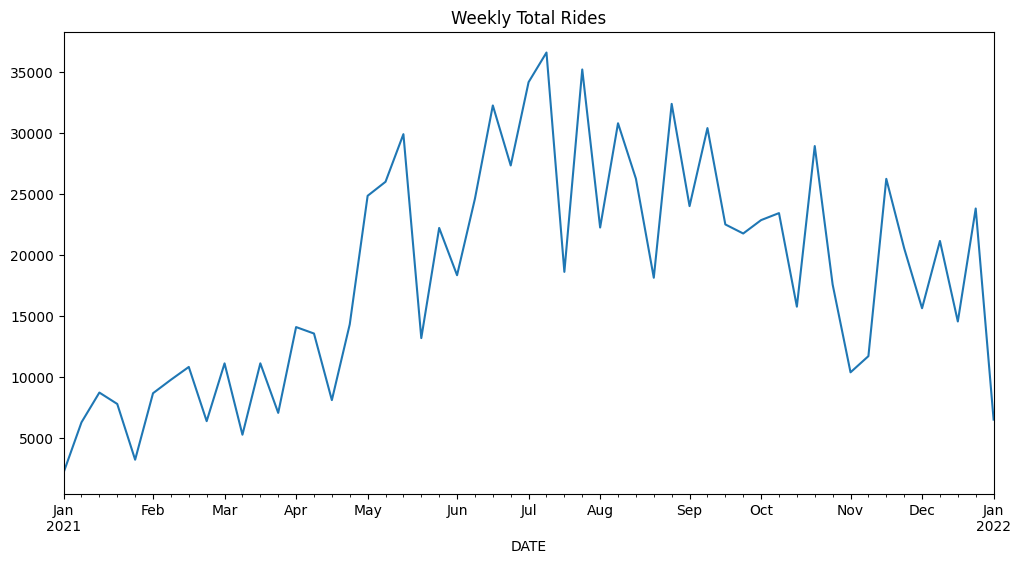

In [31]:
# Resample to weekly data
weekly_rides = df['TTLCNT'].resample('W').sum()
weekly_rides.plot(figsize=(12, 6), title='Weekly Total Rides')
plt.show()